In [1]:
from utils import *

In [2]:
import pandas as pd

DATASETS_PATH = 'data/datasets'

df = pd.read_csv(f'{DATASETS_PATH}/cortellis_A1R.csv', header=0, na_values=('NA', 'nan', 'NaN'))
# df

In [3]:
import os
from qsprpred.data.data import QSPRDataset
from qsprpred.data.utils.descriptorsets import FingerprintSet
from qsprpred.data.utils.descriptorcalculator import DescriptorsCalculator
from qsprpred.data.utils.datasplitters import scaffoldsplit

DATA_PATH_QSAR = "data/datasets/qsar"
os.makedirs(DATA_PATH_QSAR, exist_ok=True)

# create the data set
dataset = QSPRDataset(
    name="A1R",
    df=df,
    target_prop="regression_label",
    store_dir=DATA_PATH_QSAR,
)
dataset.makeClassification(th=[6.5])

In [7]:
dataset.getDF()

,SMILES,Target,regression_label,classification_label,Target_Seq,regression_label_class
0,C#CCCCCCCCCCNC(=O)Oc1cccc(-n2ccc(C(N)=O)c2)c1,P30542,5.000000,0,MPPSISAFQAAYIGIEVLIALVSVPGNVLVIWAVKVNQALRDATFC...,False
1,C#CCO[C@H]1CN2CCC1CC2.O=C(O)/C=C/C(=O)O,P30542,4.000000,0,MPPSISAFQAAYIGIEVLIALVSVPGNVLVIWAVKVNQALRDATFC...,False
2,C#CCn1c(-c2ccco2)nc2c(N)nc(C#CC3(O)CCCCC3)nc21,P30542,9.396856,-1,MPPSISAFQAAYIGIEVLIALVSVPGNVLVIWAVKVNQALRDATFC...,True
3,C#CCn1c(-c2ccco2)nc2c(N)nc(C#CCCCCCC)nc21,P30542,8.443577,-1,MPPSISAFQAAYIGIEVLIALVSVPGNVLVIWAVKVNQALRDATFC...,True
4,C#CCn1c(Br)nc2c(N)nc(C#CC3(O)CCCCC3)nc21,P30542,9.300162,-1,MPPSISAFQAAYIGIEVLIALVSVPGNVLVIWAVKVNQALRDATFC...,True
...,...,...,...,...,...,...
585,c1cncc(Nc2ncc(-c3ccncn3)c(-c3ccco3)n2)c1,P30542,6.000000,0,MPPSISAFQAAYIGIEVLIALVSVPGNVLVIWAVKVNQALRDATFC...,False
586,c1cncc(Nc2ncc(-c3ccncn3)c(-c3cccs3)n2)c1,P30542,6.000000,0,MPPSISAFQAAYIGIEVLIALVSVPGNVLVIWAVKVNQALRDATFC...,False
587,c1cncc(Nc2ncc(-c3ccnnc3)c(-c3ccco3)n2)c1,P30542,6.000000,0,MPPSISAFQAAYIGIEVLIALVSVPGNVLVIWAVKVNQALRDATFC...,False
588,c1coc(-c2nc(Nc3cncnc3)ncc2-c2ccncn2)c1,P30542,6.000000,0,MPPSISAFQAAYIGIEVLIALVSVPGNVLVIWAVKVNQALRDATFC...,False


In [8]:
# Calculate MorganFP and physicochemical properties
feature_calculator = DescriptorsCalculator(
    descsets=[FingerprintSet(fingerprint_type="MorganFP", radius=3, nBits=2048)]
)

# split on scaffolds
split = scaffoldsplit(test_fraction=0.2)

dataset.prepareDataset(split=split, feature_calculator=feature_calculator)

print(f"Number of samples train set: {len(dataset.y)}")
print(
    f"Number of samples test set: {len(dataset.y_ind)}, {len(dataset.y_ind) / len(dataset.df) * 100}%"
)

Missing values filled with nan
e:\Bioinfomatics\drug_design\venv\lib\site-packages\qsprpred\data\data.py:493: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.df[f"Scaffold_{scaffold}"] = self.apply(


Number of samples train set: 472
Number of samples test set: 118, 20.0%


# Classification

## Train

In [9]:
from qsprpred.models.models import QSPRsklearn
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

params = {
    "n_estimators": [50, 250],
    "criterion": ["gini", "entropy", "log_loss"],
    "n_jobs": [1],
}

fitted_models = []
for model in [ExtraTreesClassifier, RandomForestClassifier]:
    model = QSPRsklearn(
        name=f"cortellis_A1R_{model.__name__}",
        base_dir="data/models/qsar/",
        data=dataset,
        alg=model,
    )

    model.gridSearch(search_space_gs=params)
    model.evaluate()
    model.fit()

    fitted_models.append(model)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits


## Evaluate

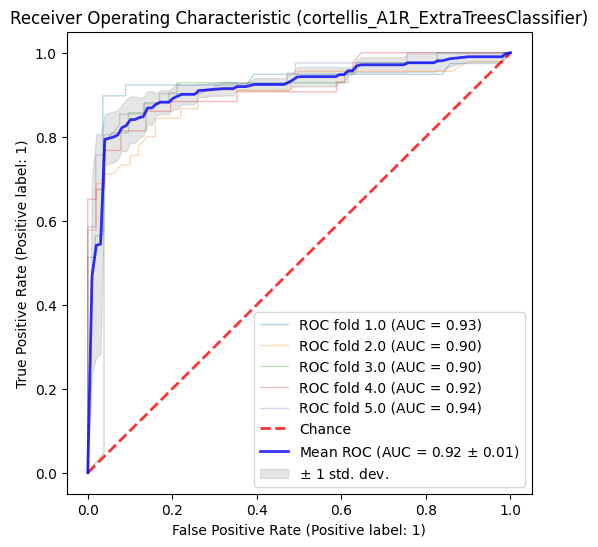

<Figure size 640x480 with 0 Axes>

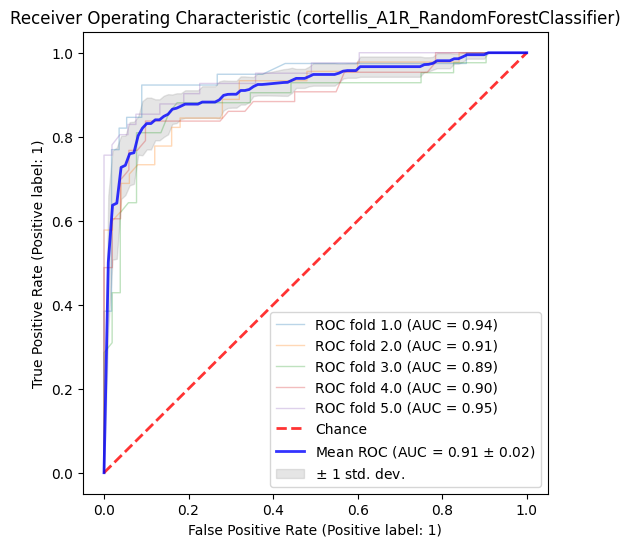

[<Figure size 600x600 with 1 Axes>, <Figure size 600x600 with 1 Axes>]

<Figure size 640x480 with 0 Axes>

In [10]:
from qsprpred.plotting.classification import ROCPlot

plot = ROCPlot(fitted_models)
plot.make("cv", save=True, show=True)

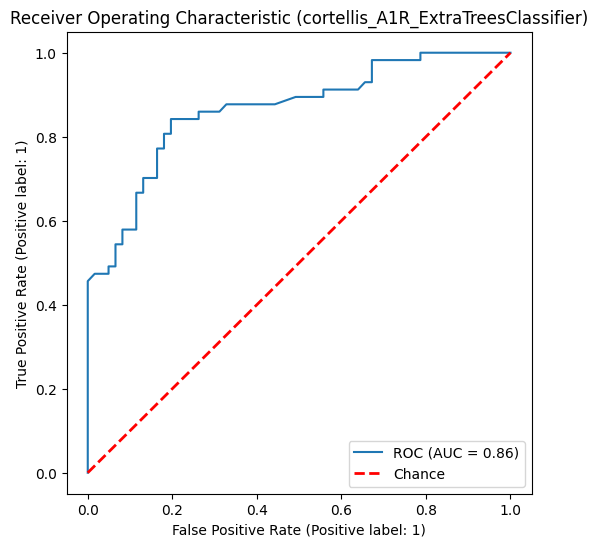

<Figure size 640x480 with 0 Axes>

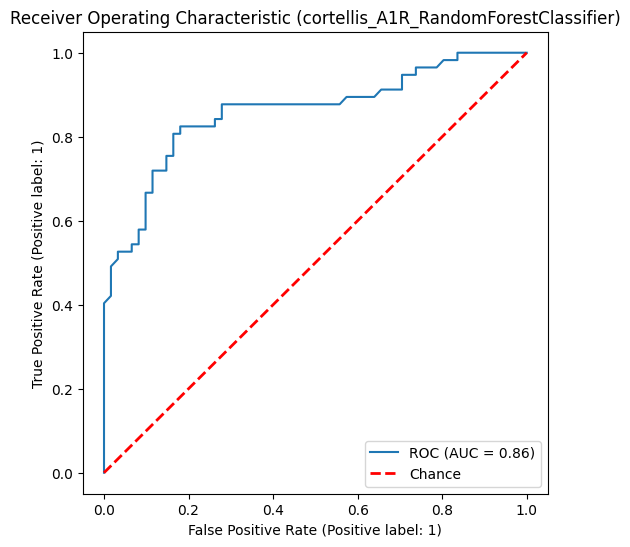

[<Figure size 600x600 with 1 Axes>, <Figure size 600x600 with 1 Axes>]

<Figure size 640x480 with 0 Axes>

In [11]:
plot.make("ind", save=True, show=True)

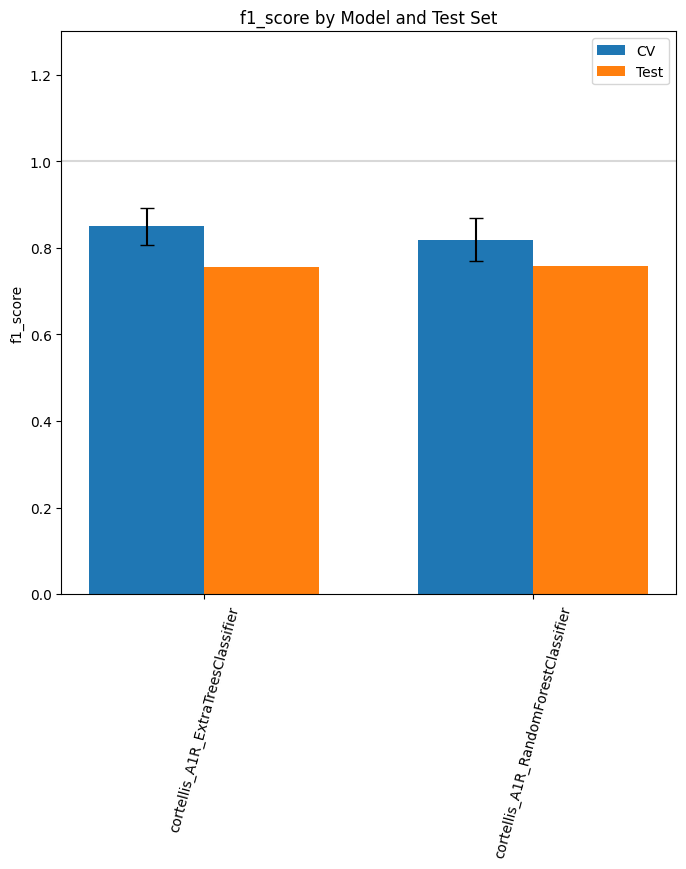

<Figure size 640x480 with 0 Axes>

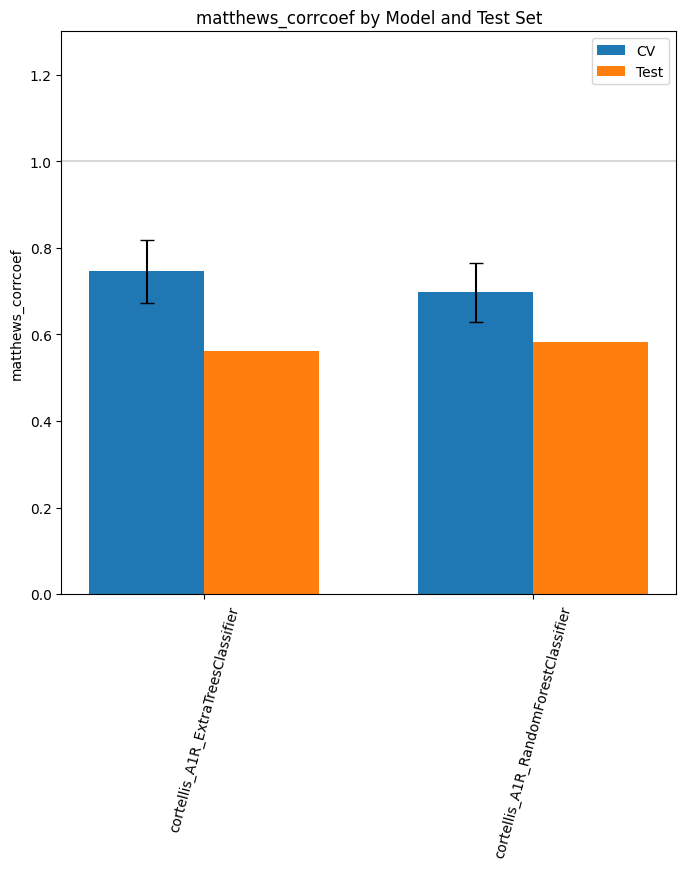

<Figure size 640x480 with 0 Axes>

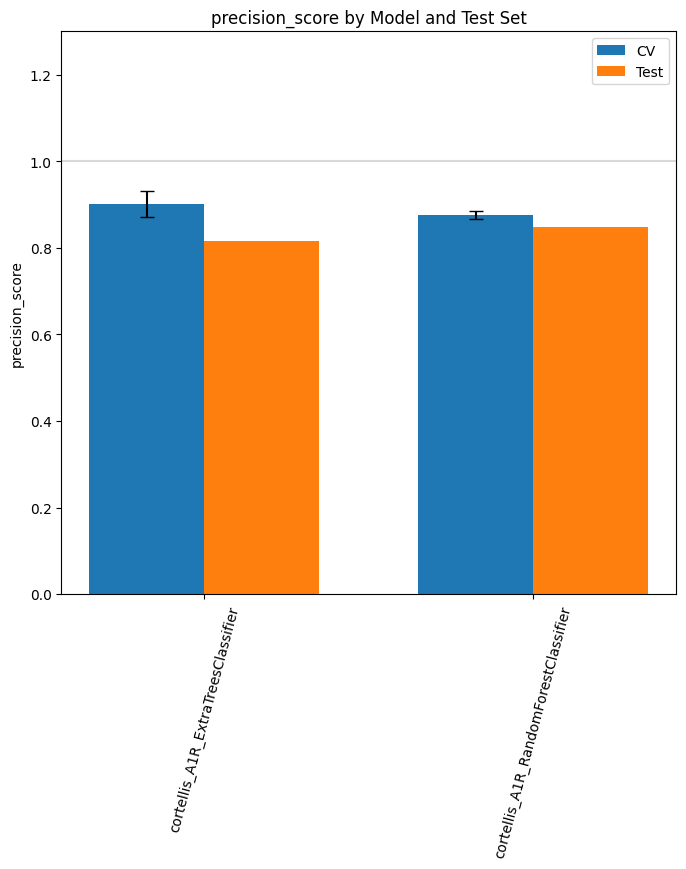

<Figure size 640x480 with 0 Axes>

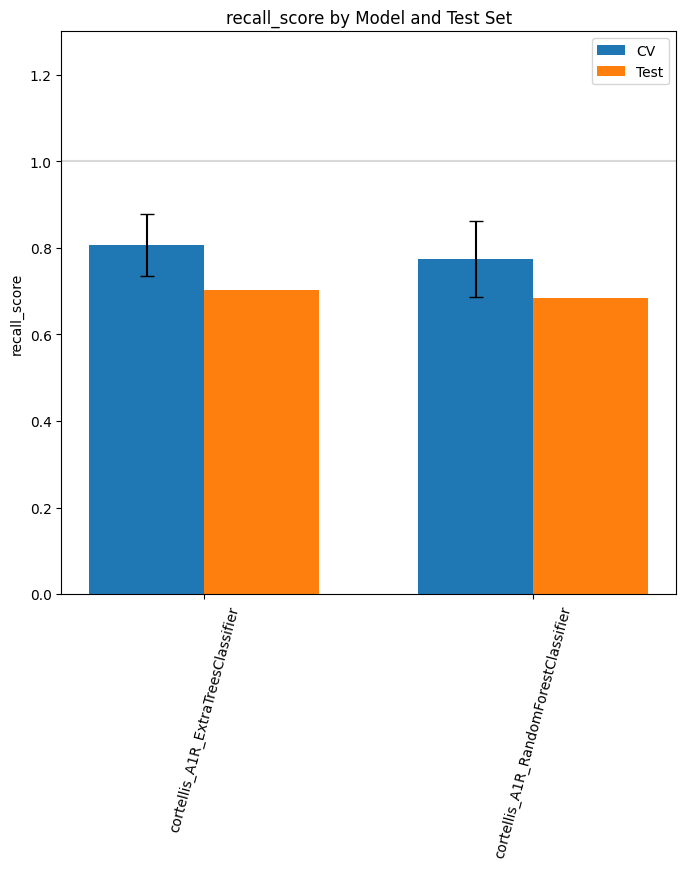

<Figure size 640x480 with 0 Axes>

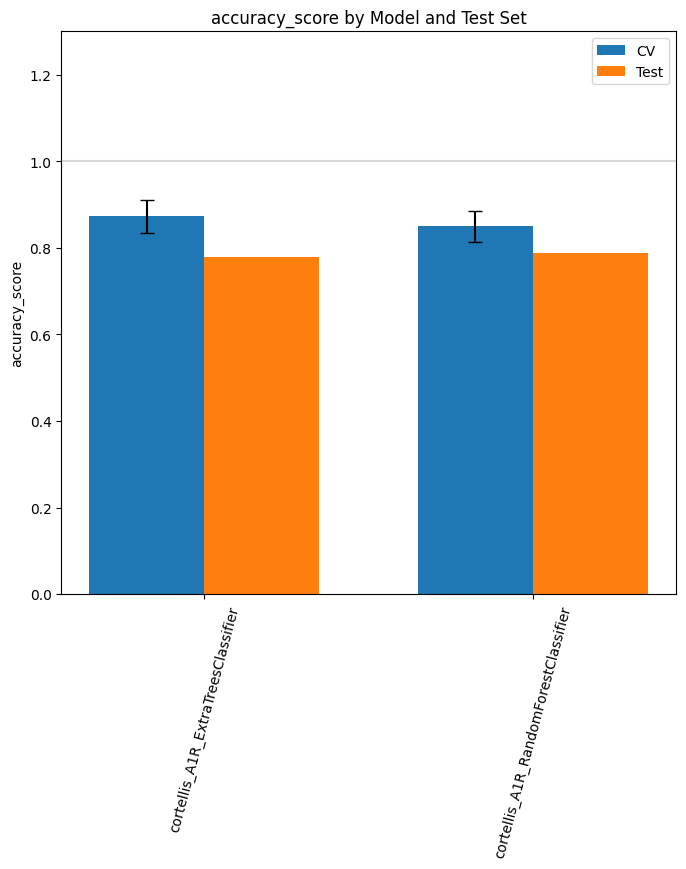

<Figure size 640x480 with 0 Axes>

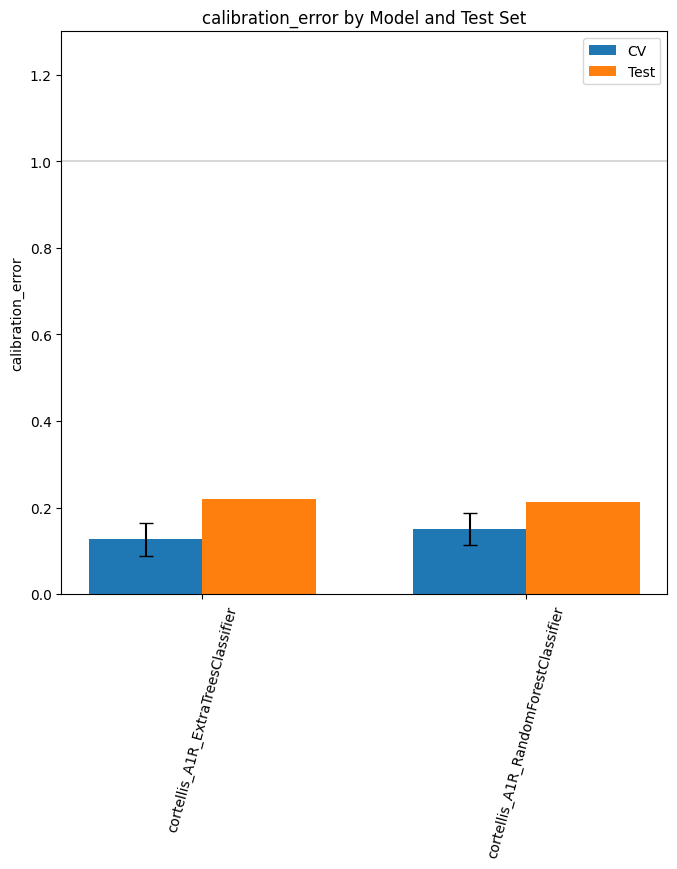

<Figure size 640x480 with 0 Axes>

In [12]:
from qsprpred.plotting.classification import MetricsPlot

plot = MetricsPlot(fitted_models)
figs, summary = plot.make(show=True, save=False)

In [13]:
# the summary contains the data frame with the metrics used to create the plots
summary

,Metric,Model,TestSet,Value
0,f1_score,cortellis_A1R_ExtraTreesClassifier,CV1.0,0.909091
1,matthews_corrcoef,cortellis_A1R_ExtraTreesClassifier,CV1.0,0.847364
2,precision_score,cortellis_A1R_ExtraTreesClassifier,CV1.0,0.921053
3,recall_score,cortellis_A1R_ExtraTreesClassifier,CV1.0,0.897436
4,accuracy_score,cortellis_A1R_ExtraTreesClassifier,CV1.0,0.926316
...,...,...,...,...
67,matthews_corrcoef,cortellis_A1R_RandomForestClassifier,IND,0.583469
68,precision_score,cortellis_A1R_RandomForestClassifier,IND,0.847826
69,recall_score,cortellis_A1R_RandomForestClassifier,IND,0.684211
70,accuracy_score,cortellis_A1R_RandomForestClassifier,IND,0.788136


# Inference

In [15]:
sample_inputs = [
    'CN1C=NC2=C1C(=O)N(C(=O)N2C)C',  # caffeine
    # SCH-58261 (50x more selective to A2A than caffeine -> more potent),
    'c1ccccc1CCN1N=CC2=C1N=C(N)N3C2=NC(C4=CC=CO4)=N3',
    # N6-Cyclopentyladenosine
    'C1CCC(C1)NC2=C3C(=NC=N2)N(C=N3)C4C(C(C(O4)CO)O)O',
    # 'OC[C@H]1O[C@@H](n2cnc3c(NC4CCCC4)ncnc32)[C@H](O)[C@@H]1O',
    # 'C1CCC(C1)NC2=C3C(=NC=N2)N(C=N3)[C@H]4[C@@H]([C@@H]([C@H](O4)CO)O)O',
]


In [17]:
for model in fitted_models:
    print(model.predictMols(sample_inputs, use_probas=True))

Missing values filled with nan
e:\Bioinfomatics\drug_design\venv\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(


[[1.    0.   ]
 [1.    0.   ]
 [0.004 0.996]]


Missing values filled with nan


[[0.932 0.068]
 [0.924 0.076]
 [0.008 0.992]]


e:\Bioinfomatics\drug_design\venv\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [19]:
from qsprpred.models.models import QSPRsklearn

model_names = ['ExtraTreesClassifier', 'RandomForestClassifier']
predictors = []

for model_name in model_names:
    predictor = QSPRsklearn(
        name=f"cortellis_A1R_{model_name}", base_dir="./data/models/qsar"
    )

    predictors.append(predictor)

In [20]:
from drugex.training.scorers.qsprpred import QSPRPredScorer

qsprpred_scorers = [QSPRPredScorer(predictor) for predictor in predictors]

# qsprpred_scorer.model.predictMols(df['SMILES'], use_probas=True)
# qsprpred_scorer.getScores(sample_inputs)
# qsprpred_scorer.getScores(df["SMILES"])

In [24]:
preds = []
for (i, qsprpred_scorer) in enumerate(qsprpred_scorers):
    pred = qsprpred_scorer.getScores(df["SMILES"])
    preds.append(pred)

    with open(f"data/result/predicted_cortellis_A1R_{model_names[i]}.csv", "w") as f:
        f.write("SMILES,Prediction\n")
        for smile, p in zip(df["SMILES"], pred):
            f.write(f"{smile},{p}\n")

Missing values filled with nan
e:\Bioinfomatics\drug_design\venv\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
Missing values filled with nan
e:\Bioinfomatics\drug_design\venv\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [23]:
import numpy as np
def BinaryCrossEntropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
    term_0 = (1-y_true) * np.log(1-y_pred + 1e-7)
    term_1 = y_true * np.log(y_pred + 1e-7)
    return -np.mean(term_0+term_1, axis=0)

In [29]:
BinaryCrossEntropy(preds[0], preds[1])

0.10627233967950013